This note book is specifically to get Carla camera settings to mimic real tesla model3

This only works with V13 of Carla - due to v14 cameras failing in different aspect ratios

Wider context:

This is a process to get to generating labelled pairs of pictures:
    1. Normal rgb cam
    2. Semantically segmented images - they label each pixel in the same photo whith special colours
    
Each colour on the semantic images relate to what matters in self driving, e.g. there is
one colour for all drivable surface/roads, one colour for lane markings, one for traffic lights etc.

So by selecting one colour, you can separate all drivable sections or lane markings etc.

Purpose of this process: to create labelled images so we could later train a model to
segment real photos into semantic. With a future view to test the model on real video 
footage captured by a tesla front camera

In [1]:
#all imports
import carla #the sim library itself
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
from matplotlib import pyplot as plt #to show images in this notebook
import time
import random


so tesla cam resolution is 4:3:
    width 1280 
    height 960 
    channels 3 (RGB)

In [2]:
# connect to the sim 
client = carla.Client('localhost', 2000)

In [3]:
world = client.get_world()
spawn_points = world.get_map().get_spawn_points()
vehicle_bp = world.get_blueprint_library().filter('*model3*')

In [ ]:
#vehicle loop to pick a good spot - press q when you like it
# press Q when you find a good position giving you good view
# of lane markings "hitting" the bottom of the image,
# horizon etc
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()

start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)

#setting RGB Camera - this follow the approach explained in a Carla video
# link: https://www.youtube.com/watch?v=om8klsBj4rc&t=1184s

#camera mount offset on the car - you can tweak these to each car to avoid any parts of the car being in the view
CAMERA_POS_Z = 1.6 #this means 1.6m up from the ground
CAMERA_POS_X = 0.9 #this is 0.9m forward

camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '1280') # this ratio works in CARLA 9.13 on Windows
camera_bp.set_attribute('image_size_y', '960')

camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
#this creates the camera in the sim
camera = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)

def camera_callback(image,data_dict):
    data_dict['image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

image_w = camera_bp.get_attribute('image_size_x').as_int()
image_h = camera_bp.get_attribute('image_size_y').as_int()

camera_data = {'image': np.zeros((image_h,image_w,4))}
# this actually opens a live stream from the camera
camera.listen(lambda image: camera_callback(image,camera_data))

for point in spawn_points:
    vehicle.set_transform(point)
    good_loc = point # so you can use that location after a stop
    time.sleep(1)
    # Dispaly with imshow
    img = camera_data['image']
    cv2.imshow('All cameras',img)
    # Break loop if user presses q
    if cv2.waitKey(75) == ord('q'):
        break
cv2.destroyAllWindows()
camera.stop() # this is the opposite of camera.listen
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

In [ ]:
#display the image you stopped the loop on above
#if it is different to where you wanted, do the above loop again

carla_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(carla_im)
plt.title('Carla')
plt.show()



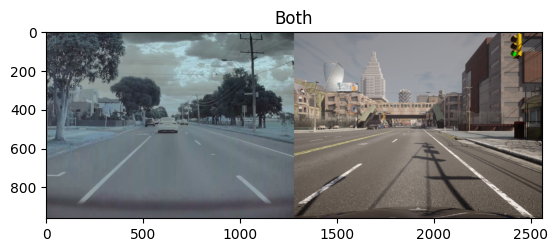

In [76]:
'''
now we can use that "good location" to try different camera mounting
points and field of view
this will generate an image from the "good spot" picked above
so you can update the parameters of the camera and view the result

Parameters to update:

1. x and z offset - camera precise mounting point on the car
 where x moves the camera forward and back
       z moves the camera up and down

2. Field of view of the camera - where the more meand wider lense and the less is longer/more zoom lense

e.g. camera_bp.set_attribute('fov', '90')
where 90 is 90 degrees angle of view

You need to play with these 3 settings (x,z,fov) to give you carla images looking most alike
to Tesla's from geometry point of view
'''
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()

start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)

#camera mount offset on the car - you can tweak these to each car to avoid any parts of the car being in the view
CAMERA_POS_Z = 1.3 #this means meters up from the ground
CAMERA_POS_X = 1.4 #this is meters forward

camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '1280') # this ratio works in CARLA 9.13 on Windows
camera_bp.set_attribute('image_size_y', '960')
camera_bp.set_attribute('fov', '90')

camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
#this creates the camera in the sim
camera = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)

def camera_callback(image,data_dict):
    data_dict['image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

image_w = camera_bp.get_attribute('image_size_x').as_int()
image_h = camera_bp.get_attribute('image_size_y').as_int()

camera_data = {'image': np.zeros((image_h,image_w,4))}
# this actually opens a live stream from the camera
camera.listen(lambda image: camera_callback(image,camera_data))

vehicle.set_transform(good_loc)
time.sleep(1)
# grab image
img = camera_data['image']

cv2.destroyAllWindows()
camera.stop() # this is the opposite of camera.listen
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

carla_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(np.concatenate((frame,carla_im),axis=1))
plt.title('Both')
plt.show()

these are parameters for camera that look closest to a real tesla
z offset = 1.3 
x offset = 1.4 

camera_bp.set_attribute('image_size_x', '1280') 
camera_bp.set_attribute('image_size_y', '960')
camera_bp.set_attribute('fov', '90')

We are now ready to start generating images while moving the car around the map

But before that we need to chage the sim into Synchronous mode
This is a fancy way of saying "speed of displaying does not matter, 
what matters is my sequence of images".
Synch mode also ensures 2 images from different cameras
at the same point in time are the same

From now on we sill start preparing to generate images, but the final scripts are in .py files

In [6]:
#setting up a car with 2 cameras
# we can use smaller images in the same spact ratio
#     1280 / 2 = 640
#     960 / 2 = 480

# clean up
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

# ensure sync mode on 
settings = world.get_settings()
settings.synchronous_mode = True
settings.fixed_delta_seconds = 0.05
world.apply_settings(settings)
    
# usual - spaw a car and set Autopilot on
vehicle_bp = world.get_blueprint_library().filter('*model3*')
start_point = spawn_points[0]
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)

vehicle.set_light_state(carla.VehicleLightState.LowBeam)

#camera mount offset on the car - you can tweak these to each car to avoid any parts of the car being in the view
CAMERA_POS_Z = 1.3 
CAMERA_POS_X = 1.4 

#semantic camera
camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.13 on Windows
camera_bp.set_attribute('image_size_y', '480')
camera_bp.set_attribute('fov', '90')

camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
camera_sem = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)

#normal rgb camera
camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.13 on Windows
camera_bp.set_attribute('image_size_y', '480')
camera_bp.set_attribute('fov', '90')
camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
camera_rgb = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)


def sem_callback(image,data_dict):
    ########## IMPORTANT CHANGE for Semantic camera ##############
    image.convert(carla.ColorConverter.CityScapesPalette)
    data_dict['sem_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))
    
def rgb_callback(image,data_dict):
    data_dict['rgb_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

image_w = 640
image_h = 480

camera_data = {'sem_image': np.zeros((image_h,image_w,4)),
               'rgb_image': np.zeros((image_h,image_w,4))}

# this actually opens a live stream from the cameras
camera_sem.listen(lambda image: sem_callback(image,camera_data))
camera_rgb.listen(lambda image: rgb_callback(image,camera_data))


# get all drivable locations on the map
all_roads = world.get_map().get_topology()

for waypoint in all_roads:
    world.tick()
    vehicle.set_transform(waypoint[0].transform)
    time.sleep(0.5)
    im_h = cv2.hconcat([camera_data['rgb_image'], camera_data['sem_image']])
    cv2.imshow('2 cameras', im_h)
    
    # Break loop if user presses q
    if cv2.waitKey(1) == ord('q'):
        break

cv2.destroyAllWindows()
camera_sem.stop() # this is the opposite of camera.listen
camera_rgb.stop() 
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

Before we start saving images, we also need to generate:
-some weather
-some traffic
however for images with traffic, we can only use the car in autopilot so we
avoid moving the car on a spot taken by another car.
So we could have several loops:
First - before traffic is introduced - moving the car with set_transform()
Second - same but for all weather conditions 
Third - in autopilot in random weather

In [5]:
# how to set the weather and time of day
weather = carla.WeatherParameters(
    cloudiness=80.0,
    precipitation=30.0,
    sun_altitude_angle=0.0,
    precipitation_deposits = 10.0,
    fog_density = 20.0,
    wetness = 15.0
)
world.set_weather(weather)

In [21]:
#now with weather loop

#Full script with all imports: it is better to re-start teh simulator each time

# create folder structure for out put images BEFORE running
# In the folder where you launch jupyter notebook, these these
# out_sem/rgb    - this folder will contain RGB images
# out_sem/sem    - thsi will contain semantic images

import carla #the sim library itself
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
from matplotlib import pyplot as plt #to show images in this notebook
import time
import random

client = carla.Client('localhost', 2000)
time.sleep(10)

world = client.get_world()
spawn_points = world.get_map().get_spawn_points()
vehicle_bp = world.get_blueprint_library().filter('*model3*')

# clean up
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

# ensure sync mode on 
settings = world.get_settings()
settings.synchronous_mode = True
settings.fixed_delta_seconds = 0.1
settings.no_rendering_mode = True
world.apply_settings(settings)
    
vehicle = world.try_spawn_actor(vehicle_bp[0], start_point)

def sem_callback(image,data_dict):
    ########## IMPORTANT CHANGE for Semantic camera ##############
    image.convert(carla.ColorConverter.CityScapesPalette)
    data_dict['sem_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))
    
def rgb_callback(image,data_dict):
    data_dict['rgb_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

if vehicle == None:
    print("Re-start the sim")
else:

    #lights always on
    vehicle.set_light_state(carla.VehicleLightState.LowBeam)

    #camera mount offset on the car - you can tweak these to each car to avoid any parts of the car being in the view
    CAMERA_POS_Z = 1.3 
    CAMERA_POS_X = 1.4 

    #semantic camera
    camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
    camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.13 on Windows
    camera_bp.set_attribute('image_size_y', '480')
    camera_bp.set_attribute('fov', '90')

    camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
    camera_sem = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)

    #normal rgb camera
    camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
    camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.13 on Windows
    camera_bp.set_attribute('image_size_y', '480')
    camera_bp.set_attribute('fov', '90')
    camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
    camera_rgb = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)


    image_w = 640
    image_h = 480

    camera_data = {'sem_image': np.zeros((image_h,image_w,4)),
                   'rgb_image': np.zeros((image_h,image_w,4))}

    # this actually opens a live stream from the cameras
    camera_sem.listen(lambda image: sem_callback(image,camera_data))
    camera_rgb.listen(lambda image: rgb_callback(image,camera_data))


    # get all drivable locations on the map
    all_roads = world.get_map().get_topology()
    #loop 1 time of day dry
    for i in range(10):
        print('Commencing cycle ',i)
        weather = carla.WeatherParameters(
                cloudiness=random.randint(0,100),
                precipitation=random.randint(0,100),
                sun_altitude_angle=random.randint(0,100),
                precipitation_deposits =random.randint(0,100),
                fog_density =random.choice([0.0,0.1,0.3,0.4,0.95]),
                wetness = random.randint(0,100))
        world.set_weather(weather)
        for waypoint in all_roads:
            world.tick()
            vehicle.set_transform(waypoint[0].transform)
            time.sleep(0.5)
            rgb_im = camera_data['rgb_image']
            sem_im = camera_data['sem_image']
            #im_h = cv2.hconcat([rgb_im,sem_im])
            #cv2.imshow('2 cameras', im_h)
            #if cv2.waitKey(1) == ord('q'):
            #    break
            #write images
            time_grab = time.time_ns()
            cv2.imwrite('out_sem/rgb/%06d.png' % time_grab, rgb_im)
            cv2.imwrite('out_sem/sem/%06d.png' % time_grab, sem_im)


    cv2.destroyAllWindows()
    camera_sem.stop() # this is the opposite of camera.listen
    camera_rgb.stop() 
    for actor in world.get_actors().filter('*vehicle*'):
        actor.destroy()
    for sensor in world.get_actors().filter('*sensor*'):
        sensor.destroy()

Commencing cycle  0
Commencing cycle  1
Commencing cycle  2
Commencing cycle  3
Commencing cycle  4
Commencing cycle  5
Commencing cycle  6
Commencing cycle  7
Commencing cycle  8
Commencing cycle  9


In [1]:
#now the same weather loop but in autopilot with other tarffic

#Full script with all imports: it is better to re-start the simulator each time

# create folder structure for out put images BEFORE running
# In the folder where you launch jupyter notebook, these these
# out_sem/rgb    - this folder will contain RGB images
# out_sem/sem    - thsi will contain semantic images

import carla #the sim library itself
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
import time
import random

client = carla.Client('localhost', 2000)
time.sleep(10)

world = client.get_world()
traffic_manager = client.get_trafficmanager(8000)

blueprints = world.get_blueprint_library().filter('*vehicle*')

spawn_points = world.get_map().get_spawn_points()
vehicle_bp = world.get_blueprint_library().filter('*model3*')

# clean up
for actor in world.get_actors().filter('*vehicle*'):
    actor.destroy()
for sensor in world.get_actors().filter('*sensor*'):
    sensor.destroy()

# ensure sync mode on 
settings = world.get_settings()
settings.synchronous_mode = True
settings.fixed_delta_seconds = 0.1
settings.no_rendering_mode = True
traffic_manager.set_synchronous_mode(True)
traffic_manager.global_percentage_speed_difference(70)

world.apply_settings(settings)
    
vehicle = world.try_spawn_actor(vehicle_bp[0], random.choice(spawn_points))

# generate traffic limeted number
counter = 0
traffic = []
random.shuffle(spawn_points)
for n, transform in enumerate(spawn_points):
    counter +=1
    if counter >15:
        break
    blueprint = random.choice(blueprints)
    traffic_vehicle = world.try_spawn_actor(blueprint, transform)
    if traffic_vehicle != None:# spawn the cars and set their autopilot and light state all together
        traffic.append(traffic_vehicle)
        traffic_vehicle.set_autopilot(True)

def sem_callback(image,data_dict):
    ########## IMPORTANT CHANGE for Semantic camera ##############
    image.convert(carla.ColorConverter.CityScapesPalette)
    data_dict['sem_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))
    
def rgb_callback(image,data_dict):
    data_dict['rgb_image'] = np.reshape(np.copy(image.raw_data),(image.height,image.width,4))

if vehicle == None:
    print("Re-start the sim")
else:
    #lights always on
    vehicle.set_light_state(carla.VehicleLightState.LowBeam)
    vehicle.set_autopilot(True)
    
    #camera mount offset on the car - you can tweak these to each car to avoid any parts of the car being in the view
    CAMERA_POS_Z = 1.3 
    CAMERA_POS_X = 1.4 

    #semantic camera
    camera_bp = world.get_blueprint_library().find('sensor.camera.semantic_segmentation')
    camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.13 on Windows
    camera_bp.set_attribute('image_size_y', '480')
    camera_bp.set_attribute('fov', '90')

    camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
    camera_sem = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)

    #normal rgb camera
    camera_bp = world.get_blueprint_library().find('sensor.camera.rgb')
    camera_bp.set_attribute('image_size_x', '640') # this ratio works in CARLA 9.13 on Windows
    camera_bp.set_attribute('image_size_y', '480')
    camera_bp.set_attribute('fov', '90')
    camera_init_trans = carla.Transform(carla.Location(z=CAMERA_POS_Z,x=CAMERA_POS_X))
    camera_rgb = world.spawn_actor(camera_bp,camera_init_trans,attach_to=vehicle)


    image_w = 640
    image_h = 480

    camera_data = {'sem_image': np.zeros((image_h,image_w,4)),
                   'rgb_image': np.zeros((image_h,image_w,4))}

    # this actually opens a live stream from the cameras
    camera_sem.listen(lambda image: sem_callback(image,camera_data))
    camera_rgb.listen(lambda image: rgb_callback(image,camera_data))


    # get all drivable locations on the map
    all_roads = world.get_map().get_topology()
    #loop 1 time of day dry
    for i in range(2):
        print('Commencing cycle ',i)
        weather = carla.WeatherParameters(
                cloudiness=random.randint(0,100),
                precipitation=random.randint(0,100),
                sun_altitude_angle=random.randint(0,100),
                precipitation_deposits =random.randint(0,100),
                fog_density =random.choice([0.0,0.1,0.3,0.4,0.95]),
                wetness = random.randint(0,100))
        world.set_weather(weather)
        img_counter = 0
        prev_position = vehicle.get_transform()
        while img_counter < 200:
            world.tick()
            current_position = vehicle.get_transform()
            rgb_im = camera_data['rgb_image']
            sem_im = camera_data['sem_image']
            im_h = cv2.hconcat([rgb_im,sem_im])
            cv2.imshow('2 cameras', im_h)
            if cv2.waitKey(1) == ord('q'):
                break
            #write images
            if current_position.location.distance(prev_position.location)>10:
                prev_position = current_position
                img_counter += 1
                time_grab = time.time_ns()
                #cv2.imwrite('out_sem/rgb/%06d.png' % time_grab, rgb_im)
                #cv2.imwrite('out_sem/sem/%06d.png' % time_grab, sem_im)
        cv2.destroyAllWindows()


    cv2.destroyAllWindows()
    camera_sem.stop() # this is the opposite of camera.listen
    camera_rgb.stop() 
    for actor in world.get_actors().filter('*vehicle*'):
        actor.destroy()
    for sensor in world.get_actors().filter('*sensor*'):
        sensor.destroy()

Commencing cycle  0


error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\matrix_operations.cpp:67: error: (-215:Assertion failed) src[i].dims <= 2 && src[i].rows == src[0].rows && src[i].type() == src[0].type() in function 'cv::hconcat'


In [1]:
#generate traffic example

import carla #the sim library itself
import cv2 #to work with images from cameras
import numpy as np #in this example to change image representation - re-shaping
from matplotlib import pyplot as plt #to show images in this notebook
import time
import random

client = carla.Client('localhost', 2000)
time.sleep(10)

world = client.get_world()
traffic_manager = client.get_trafficmanager(8000)

blueprints = world.get_blueprint_library().filter('*vehicle*')

spawn_points = world.get_map().get_spawn_points()

# ensure sync mode on 
settings = world.get_settings()
settings.synchronous_mode = True
settings.fixed_delta_seconds = 0.1
settings.no_rendering_mode = True
traffic_manager.set_synchronous_mode(True)
traffic_manager.global_percentage_speed_difference(70)

world.apply_settings(settings)


counter = 0
traffic = []
for n, transform in enumerate(random.shuffle(spawn_points):
    counter +=1
    if counter >15:
        break
    blueprint = random.choice(blueprints)
    traffic_vehicle = world.try_spawn_actor(blueprint, transform)
    if traffic_vehicle != None:# spawn the cars and set their autopilot and light state all together
        traffic.append(traffic_vehicle)
        traffic_vehicle.set_autopilot(True)


SyntaxError: invalid syntax (3502441884.py, line 33)

In [4]:
random.shuffle(spawn_points)